In [ ]:
!pip install -qq transformers --quiet

     |████████████████████████████████| 1.3MB 4.8MB/s 
     |████████████████████████████████| 2.9MB 31.8MB/s 
     |████████████████████████████████| 1.1MB 52.2MB/s 
     |████████████████████████████████| 890kB 49.1MB/s 


In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving adverse_media_dataset_final.csv to adverse_media_dataset_final.csv
User uploaded file "adverse_media_dataset_final.csv" with length 47824 bytes


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from matplotlib import style
import numpy as np
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

%matplotlib inline
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch


#sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 5, 5

style.use('dark_background')

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import warnings
warnings.filterwarnings('ignore')

In [ ]:
pd.set_option('max_rows',99999)
pd.set_option('max_colwidth',400)
pd.describe_option('max_colwidth')

display.max_colwidth : int or None
    The maximum width in characters of a column in the repr of
    a pandas data structure. When the column overflows, a "..."
    placeholder is embedded in the output. A 'None' value means unlimited.
    [default: 50] [currently: 400]


In [ ]:
df = pd.read_csv('/content/adverse_media_dataset_final.csv')

In [ ]:
df.head()

,title,label
0,Astellas Pharma Inc. -- Moody's announces comp...,0
1,Form N-CSRS Fidelity Rutland Square For: Nov 30,0
2,Astellas Pharma Inc. -- Moody's announces comp...,0
3,Form N-CSRS Fidelity Rutland Square For: Nov 30,0
4,"Worker dead, several others injured in ammonia...",-1


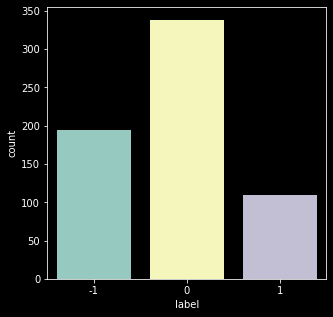

In [ ]:
sns.countplot(x = df.label)
plt.show()

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
encoding.keys()

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'When',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [ ]:
max_len = 0
type(max_len)

int

In [ ]:
max_len = 0
token_lens = []

for txt in df.title:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))
    if len(tokens)>max_len:
        max_len = len(tokens)   
max_len

49

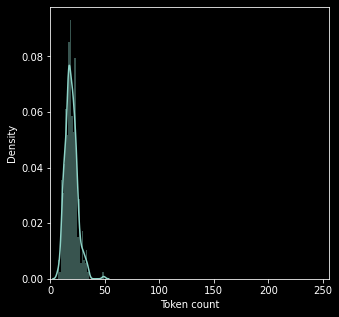

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [ ]:
label_dict = {-1:0,0:1,1:2}
df.label = df.label.map(label_dict)

## Data Loader

In [ ]:
MAX_LEN = 50

In [ ]:
class AdvNewsDataset(Dataset):
  def __init__(self, news, labels, tokenizer, max_len):
    self.news = news
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.news)
  def __getitem__(self, item):
    news = str(self.news[item])
    label = self.labels[item]

    encoding = self.tokenizer.encode_plus(
      news,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'news_text': news,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'labels': torch.tensor(label, dtype=torch.long)
    }

In [ ]:
df_train, df_test = train_test_split(
  df,
  test_size=0.1,
  random_state=42
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=42
)
df_train.shape, df_val.shape, df_test.shape

((577, 2), (32, 2), (33, 2))

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = AdvNewsDataset(
    news=df.title.to_numpy(),
    labels=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['news_text', 'input_ids', 'attention_mask', 'labels'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['labels'].shape)

torch.Size([16, 50])
torch.Size([16, 50])
torch.Size([16])


## Model

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

In [ ]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [ ]:
bert_model.config.hidden_size

768

In [ ]:
pooled_output.shape

torch.Size([1, 768])

In [ ]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
model = SentimentClassifier(3)
model = model.to(device)

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 50])
torch.Size([16, 50])


In [ ]:
# F.softmax(model(input_ids, attention_mask), dim=1)

### Training

In [ ]:
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    labels = d["labels"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)
    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["labels"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels)
      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 1.0171063719569027 accuracy 0.5476603119584055
Val loss 0.7079071700572968 accuracy 0.75

Epoch 2/10
----------
Train loss 0.5130693123147294 accuracy 0.8440207972270364
Val loss 0.8098315000534058 accuracy 0.78125

Epoch 3/10
----------
Train loss 0.257413783991659 accuracy 0.925476603119584
Val loss 0.5076064914464951 accuracy 0.90625

Epoch 4/10
----------
Train loss 0.16817442060926477 accuracy 0.9549393414211438
Val loss 0.5838649123907089 accuracy 0.875

Epoch 5/10
----------
Train loss 0.11391893846008021 accuracy 0.9601386481802425
Val loss 0.6301009953022003 accuracy 0.875

Epoch 6/10
----------
Train loss 0.09708423782265871 accuracy 0.9618717504332756
Val loss 0.8702333867549896 accuracy 0.84375

Epoch 7/10
----------
Train loss 0.06732016783585218 accuracy 0.975736568457539
Val loss 0.8866474032402039 accuracy 0.84375

Epoch 8/10
----------
Train loss 0.05918857182778821 accuracy 0.9740034662045061
Val loss 0.9205548763275146 accuracy 0.8437

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

0.8484848484848485

## Visualization and Inference

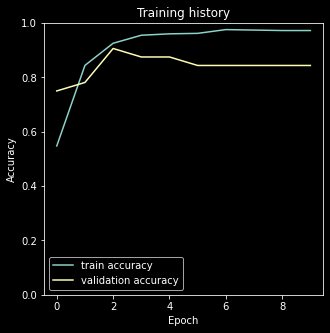

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  news_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["news_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["labels"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      news_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(labels)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return news_texts, predictions, prediction_probs, real_values

In [ ]:
y_news_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
class_names = df.label.unique().astype(str).tolist()
class_names.sort()

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.82      0.88      0.85        16
           2       0.83      0.71      0.77         7

    accuracy                           0.85        33
   macro avg       0.85      0.83      0.84        33
weighted avg       0.85      0.85      0.85        33



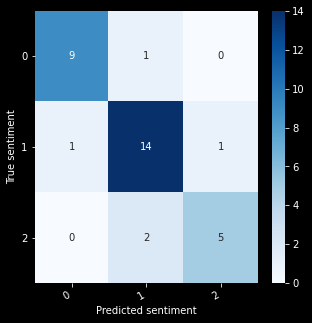

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

### Test on sample data

In [ ]:
len(y_news_texts)

33

In [ ]:
decod_dict = {0:'negative',1:'neutral',2:'positive'}

In [ ]:
pred_df = pd.DataFrame({
  'news_text': y_news_texts,
   'pred_val': map(decod_dict.get,y_pred.tolist()),
  'true_val' : map(decod_dict.get,y_test.tolist())

})
pred_df

,news_text,pred_val,true_val
0,Flipkart shuts down and Amazon limits orders for 1.3 billion Indians under lockdown,negative,negative
1,Energy News Monitor | Volume XVI; Issue 49,neutral,neutral
2,Want Security with Tax Savings? Go for Liberty Health Insurance,neutral,neutral
3,Astellas Pharma Inc. -- Moody's announces completion of a periodic review of ratings of Astellas Pharma Inc.,neutral,neutral
4,"Air India, Bharat Petroleum Corporation to be sold by March: FM Nirmala Sitharaman",positive,neutral
5,"After Amazon, Walmart's Flipkart Challenges Antitrust Probe",negative,negative
6,"In a major setback to China, UK all set to phase out Huawei's 5G infrastructure",negative,negative
7,Brace for load-shedding again,neutral,negative
8,"900,000 Virgin Media customers affected by data breach",negative,negative
9,Delhi violence: Shoot at sight orders issued in northeast Delhi,negative,negative


### False Neutral/Positives

In [ ]:
pred_df.loc[pred_df['true_val'].isin(['negative']) & pred_df['pred_val'].isin(['positive','neutral']) ]

,news_text,pred_val,true_val
7,Brace for load-shedding again,neutral,negative


### True Negatives

In [ ]:
pred_df.loc[pred_df['true_val'].isin(['negative']) & pred_df['pred_val'].isin(['negative']) ]

,news_text,pred_val,true_val
0,Flipkart shuts down and Amazon limits orders for 1.3 billion Indians under lockdown,negative,negative
5,"After Amazon, Walmart's Flipkart Challenges Antitrust Probe",negative,negative
6,"In a major setback to China, UK all set to phase out Huawei's 5G infrastructure",negative,negative
8,"900,000 Virgin Media customers affected by data breach",negative,negative
9,Delhi violence: Shoot at sight orders issued in northeast Delhi,negative,negative
11,CVS has temporarily closed about 60 stores amid looting and protests,negative,negative
17,France’s Nationwide Strike On December 5 Could Be The Biggest In Decades,negative,negative
24,"Kishore Biyani, India's Modern Retail King, Faces Trial by Fire as Debt Soars",negative,negative
31,"Huawei Technologies, ZTE are national security threats, says FCC",negative,negative
